In [1]:
import numpy as np
import awkward as ak
import tensorflow as tf
import matplotlib.pyplot as plt

from hepinfo.models.MiVAE import MiVAE
from hepinfo.util import readFromAnomalyBackgroundh5, readFromAnomalySignalh5, awkward_to_numpy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

from functools import partial

from scipy.stats import ks_2samp

from qkeras import quantized_bits
from qkeras.utils import _add_supported_quantized_objects
co = {}; _add_supported_quantized_objects(co)

import h5py
import mplhep
mplhep.style.use('CMS')

In [2]:
# read in the data
normal_data = np.load("../data/normal_data.npy", allow_pickle=True)
abnormal_data = np.load("../data/abnormal_data.npy", allow_pickle=True)

In [3]:
# perform some pre-processing and split into train test
nPV = normal_data[:,0]
nPV_abnormal = abnormal_data[:,0]
X = normal_data[:,1:]
abnormal_data = abnormal_data[:,1:]

X_train, X_test, nPV_train, nPV_test = train_test_split(X, nPV, shuffle=True)
abnormal_data_train, abnormal_data_test, nPV_abnormal_train, nPV_abnormal_test = train_test_split(abnormal_data, nPV_abnormal, shuffle=True)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
abnormal_data_train_scaled = scaler.transform(abnormal_data_train)
abnormal_data_test_scaled = scaler.transform(abnormal_data_test)

In [4]:
def custom_scorer(estimator, X, y, abnormal_data_train_scaled):
    kl_loss = estimator.score_vector(X)[1]
    mean_loss = estimator.get_mean(X).numpy()
    sigma_loss = estimator.get_sigma(X).numpy()

    kl_loss_abnorm = estimator.score_vector(abnormal_data_train_scaled)[1]
    mean_loss_abnorm = estimator.get_mean(abnormal_data_train_scaled).numpy()
    sigma_loss_abnorm = estimator.get_sigma(abnormal_data_train_scaled).numpy()

    X = np.column_stack((kl_loss, mean_loss, sigma_loss))
    X_abnorm = np.column_stack((kl_loss_abnorm, mean_loss_abnorm, sigma_loss_abnorm))
    X_total = np.concatenate((X_abnorm, X))
    X_total = np.nan_to_num(X_total)
    y = np.concatenate((np.ones(len(abnormal_data_train_scaled)), np.zeros(len(X))))

    X_train, X_test, y_train, y_test = train_test_split(X_total, y, shuffle=True, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    reg = linear_model.LogisticRegression()
    reg.fit(X_train, y_train)
    auc = roc_auc_score(y_test, reg.predict_proba(X_test)[:,1])

    return auc

scorer = partial(custom_scorer, abnormal_data_train_scaled=abnormal_data_train_scaled)

param_grid = {
    'hidden_layers': [[32, 16], [64, 32]],  # Different network architectures
    'activation': ['relu', 'tanh', 'sigmoid'],  # Different activation functions
    'latent_dims': [4, 8, 16],  # Latent space dimensions
    'drop_out': [0.0, 0.2, 0.4],  # Dropout rates
    'beta_param': [1, 10, 100],  # Weight for KL loss
    'gamma': [1, 10, 100],
    'batch_size': [32, 64, 128, 256],  # Batch sizes
    'learning_rate': [0.001, 0.0001],  # Learning rates
    'optimizer': ['Adam'],  # Different optimizers
    'epoch': [10, 50, 100],  # Number of epochs
    'quantize': [True],
    'num_samples': [10]
}

MiVAE_model = MiVAE(verbose=0, run_eagerly=False, epoch=100, batch_size=256, latent_dims=8, drop_out=0)

grid_search = RandomizedSearchCV(
    MiVAE_model,
    param_grid,
    cv=3,
    n_jobs=1,
    n_iter=10,
    verbose=3,
    scoring=scorer,
    refit=True
)
grid_search.fit(X_train, nPV_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
# train the model
MiVAE_model = MiVAE(
    verbose=2,
    activation="relu",
    use_qkeras=False,
    batch_size=256,
    beta_param=1,
    drop_out=0.0,
    epoch=100,
    gamma=10,
    num_samples=10,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    patience=100,
    quantize=True,
    run_eagerly=False
)
history = MiVAE_model.fit(X_train, nPV_train)

MiVAE_model_gamma_zero = MiVAE(
    verbose=2,
    activation="relu",
    use_qkeras=True,
    batch_size=256,
    beta_param=1,
    drop_out=0.2,
    epoch=20,
    gamma=0,
    num_samples=10,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    quantize=True,
    run_eagerly=False
)
history_gamma_zero = MiVAE_model_gamma_zero.fit(X_train, nPV_train)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 57)]                 0         []                            
                                                                                                  
 tf.cast_14 (TFOpLambda)     (None, 57)                   0         ['input_4[0][0]']             
                                                                                                  
 tf.linalg.matmul_7 (TFOpLa  (None, 32)                   0         ['tf.cast_14[0][0]']          
 mbda)                                                                                            
                                                                                                  
 tf.cast_15 (TFOpLambda)     (None, 32)                   0         ['tf.linalg.matmul_7[0][

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 tf.cast_26 (TFOpLambda)     (None, 8)                 0         
                                                                 
 tf.linalg.matmul_11 (TFOpL  (None, 16)                0         
 ambda)                                                          
                                                                 
 tf.cast_27 (TFOpLambda)     (None, 16)                0         
                                                                 
 tf.math.add_12 (TFOpLambda  (None, 16)                0         
 )                                                               
                                                                 
 tf.nn.relu_8 (TFOpLambda)   (None, 16)                0   

Epoch 1/100
586/586 - 1s - loss: 0.2703 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 2/100
586/586 - 1s - loss: 0.2697 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0016 - 525ms/epoch - 896us/step
Epoch 3/100
586/586 - 1s - loss: 0.2701 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0017 - 515ms/epoch - 879us/step
Epoch 4/100
586/586 - 0s - loss: 0.2704 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0017 - 498ms/epoch - 851us/step
Epoch 5/100
586/586 - 0s - loss: 0.2703 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0017 - 490ms/epoch - 837us/step
Epoch 6/100
586/586 - 1s - loss: 0.2699 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0016 - 500ms/epoch - 853us/step
Epoch 7/100
586/586 - 0s - loss: 0.2702 - reconstruction_loss: 0.1186 - kl_loss: 0.1349 - mi_loss: 0.0017 - 494ms/epoch - 844us/step
Epoch 8/100
586/586 - 1s - loss: 0.2702 - reconstruction_loss: 0.1186 - kl

In [7]:
# plot scripts

def do_ks_test(a, b, name):
    ks_stat, p_value = ks_2samp(a, b)

    if p_value < 0.05:
        print(f"The distributions for {name} are significantly different value={round(ks_stat, 3)}.")
    else:
        print(f"No significant difference between the distributions for {name} with value={round(ks_stat, 3)}.")

def plot_history(history):
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['reconstruction_loss'], label='Train Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='Train KL Loss')
    plt.plot(history.history['mi_loss'], label='Train MI Loss')
    plt.yscale("log")
    plt.ylabel("Total loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_score(normal_score, abnormal_score, bin_size=100, xlabel="Reconstruction Loss", ylabel="Probability (a.u.)", label_normal="dijet+ttbar", label_abnormal="higgs"):
    # get range for peak
    combined = np.concatenate([normal_score, abnormal_score])
    lower_bound = np.percentile(combined, 1)
    upper_bound = np.percentile(combined, 99)

    plt.hist(normal_score, bins=bin_size, label=label_normal, density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.hist(abnormal_score, bins=bin_size, label=label_abnormal, density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

def plot_roc(y_test, y_pred, name="Reconstruction"):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr, tpr)

    # find the index of the maximum Youden's J
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    best_threshold = thresholds[best_index]

    plt.scatter(fpr[best_index], tpr[best_index])
    plt.plot(fpr, tpr, "-", label=f"{name} (auc = {round(auc_value, 3)})", linewidth=1.5)
    return best_threshold

def get_plots(model, normal_data, abnormal_data, nPV_normal, nPV_abnormal, name=r"$\gamma=0$", use_axio=False, label_normal="dijet+ttbar", label_abnormal="higgs"):

    if use_axio:
        normal_score = model.predict(normal_data)
        normal_score = np.sum(normal_score**2, axis=1)
        abnormal_score = model.predict(abnormal_data)
        abnormal_score = np.sum(abnormal_score**2, axis=1)

        plot_score(normal_score, abnormal_score, xlabel=r"$\sum \mu^2$ score axol1tl", ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)

        # generate plots for the ROC curves
        y_test = np.concatenate((np.ones(len(abnormal_score)), np.zeros(len(normal_score))))
        thr = plot_roc(y_test, np.concatenate((abnormal_score, normal_score)), name=r"$\sum \mu^2$ score axol1tl")

        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
        plt.show()

        # generate plots for pile-up studies
        bins = 20

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)

        if not nPV_normal is None: plt.hist(nPV_normal[normal_score > thr], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sum \mu^2$ score cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[abnormal_score > thr], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sum \mu^2$ score cut")

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[normal_score > thr], label_normal + " $\sum \mu^2$ score")
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[abnormal_score > thr], label_abnormal + " $\sum \mu^2$ score")


    else:
        recon_normal_score = np.nan_to_num(model.score_vector(normal_data)[0])
        recon_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[0])

        kl_normal_score = np.nan_to_num(model.score_vector(normal_data)[1])
        kl_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[1])

        total_normal_score = np.nan_to_num(model.score_vector(normal_data)[2])
        total_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[2])
        
        mean_normal_score = model.get_mean(normal_data).numpy()
        mean_normal_score = np.sum(mean_normal_score**2, axis=1)
        mean_abnormal_score = model.get_mean(abnormal_data).numpy()
        mean_abnormal_score = np.sum(mean_abnormal_score**2, axis=1)

        sigma_normal_score = model.get_sigma(normal_data).numpy()
        sigma_normal_score = np.sum(sigma_normal_score**2, axis=1)
        sigma_abnormal_score = model.get_sigma(abnormal_data).numpy()
        sigma_abnormal_score = np.sum(sigma_abnormal_score**2, axis=1)

        plot_score(recon_normal_score, recon_abnormal_score, xlabel="Reconstruction score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(kl_normal_score, kl_abnormal_score, xlabel="KL score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(total_normal_score, total_abnormal_score, xlabel="Total score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(mean_normal_score, mean_abnormal_score, xlabel=r"$\sum \mu^2$ score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(sigma_normal_score, sigma_abnormal_score, xlabel=r"$\sum \sigma^2$ score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)

        # generate plots for the ROC curves
        y_test = np.concatenate((np.ones(len(recon_abnormal_score)), np.zeros(len(recon_normal_score))))
        thr_recon = plot_roc(y_test, np.concatenate((recon_abnormal_score, recon_normal_score)), name="Reconstruction score " + name)
        thr_kl = plot_roc(y_test, np.concatenate((kl_abnormal_score, kl_normal_score)), name="KL score " + name)
        thr_total = plot_roc(y_test, np.concatenate((total_abnormal_score, total_normal_score)), name="Total score " + name)
        thr_mean = plot_roc(y_test, np.concatenate((mean_abnormal_score, mean_normal_score)), name=r"$\sum \mu^2$ score " + name)
        thr_sigma = plot_roc(y_test, np.concatenate((sigma_abnormal_score, sigma_normal_score)), name=r"$\sum \sigma^2$ score " + name)

        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
        plt.show()

        # generate plots for pile-up studies
        bins = 20

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)

        if not nPV_normal is None: plt.hist(nPV_normal[recon_normal_score > thr_recon], bins=bins, density=True, alpha=0.3, label=f"{label_normal} recon cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[recon_abnormal_score > thr_recon], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} recon cut")

        if not nPV_normal is None: plt.hist(nPV_normal[kl_normal_score > thr_kl], bins=bins, density=True, alpha=0.3, label=f"{label_normal} KL cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[kl_abnormal_score > thr_kl], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} KL cut")

        if not nPV_normal is None: plt.hist(nPV_normal[total_normal_score > thr_total], bins=bins, density=True, alpha=0.3, label=f"{label_normal} total cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[total_abnormal_score > thr_total], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} total cut")

        if not nPV_normal is None: plt.hist(nPV_normal[mean_normal_score > thr_mean], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sum \mu^2$ score cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[mean_abnormal_score > thr_mean], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sum \mu^2$ score cut " + name)

        if not nPV_normal is None: plt.hist(nPV_normal[sigma_normal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sigma \mu^2$ score cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[sigma_abnormal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sigma \mu^2$ score cut " + name)

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[recon_normal_score > thr_recon], label_normal + " recon cut")
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[recon_abnormal_score > thr_recon], label_abnormal + " recon cut")
        
        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[kl_normal_score > thr_kl], label_normal + " KL cut")
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[kl_abnormal_score > thr_kl], label_abnormal + " KL cut")

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[total_normal_score > thr_total], label_normal + " total cut")
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[total_abnormal_score > thr_total], label_abnormal + " total cut")

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[mean_normal_score > thr_mean], label_normal + r" $\sum \mu^2$ score cut " + name)
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[mean_abnormal_score > thr_mean], label_abnormal + r" $\sum \mu^2$ score cut " + name)

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[sigma_normal_score > thr_sigma], label_normal + r" $\sigma \mu^2$ score cut " + name)
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[sigma_abnormal_score > thr_sigma], label_abnormal + r" $\sigma \mu^2$ score cut " + name)

    if nPV_normal is not None or nPV_abnormal is not None:
        plt.xlabel("nPV")
        plt.ylabel("Events (%)")

        plt.legend(loc='best', ncol=2, prop={'size': 8})
        plt.grid(True)

        plt.show()


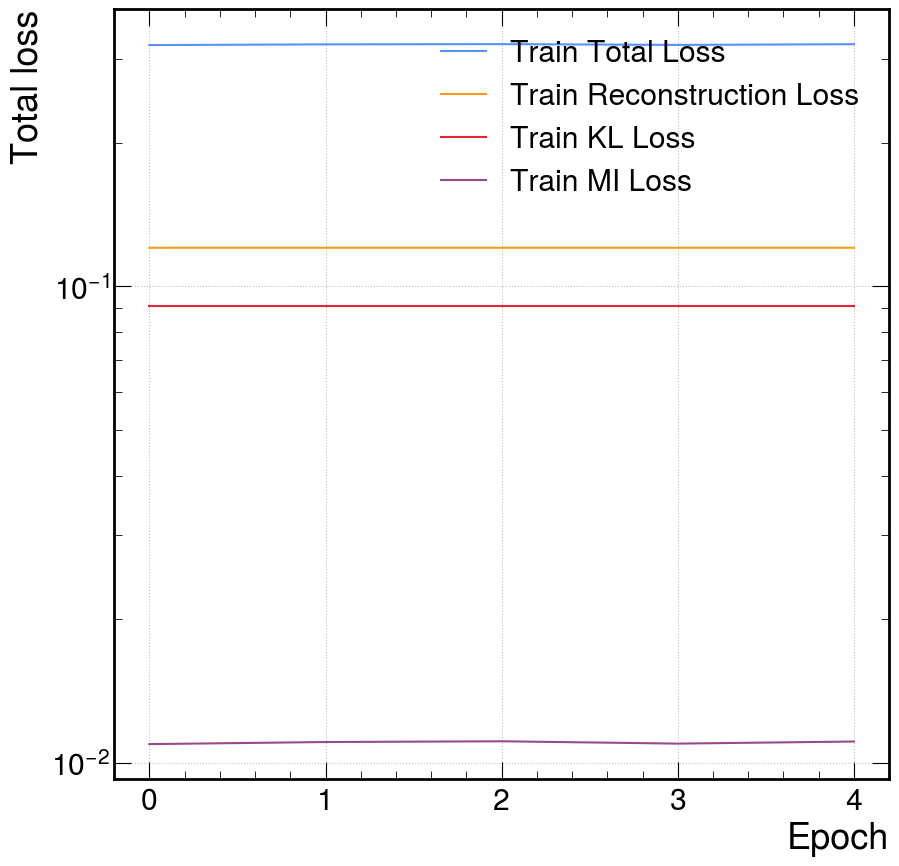

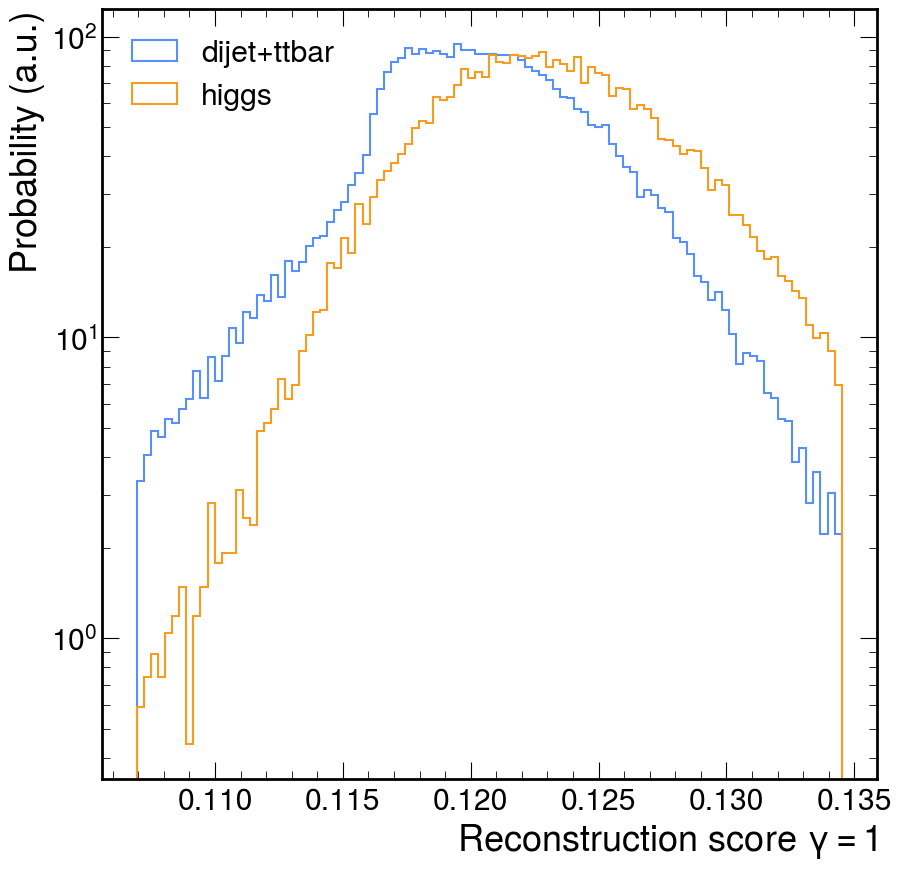

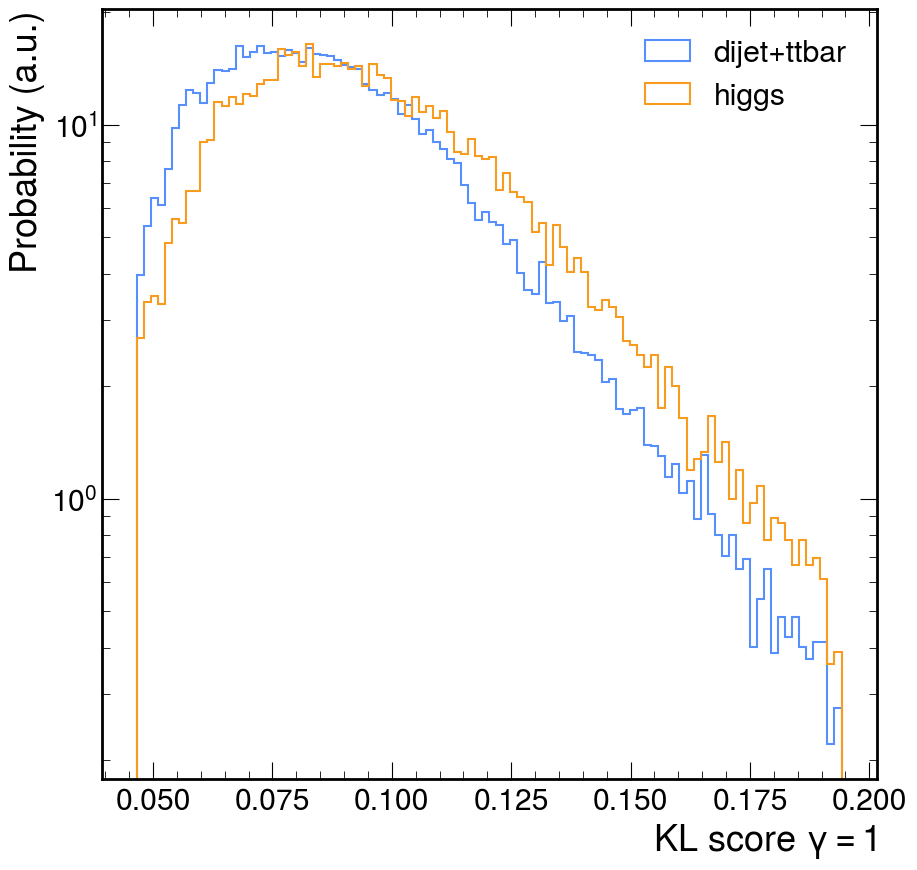

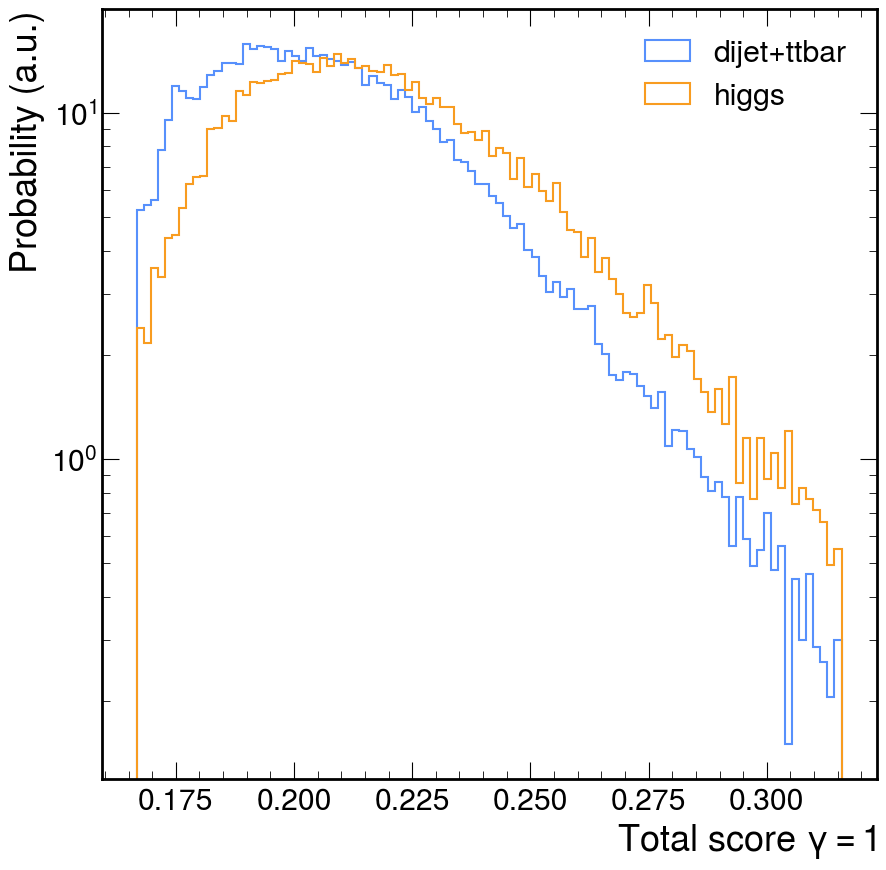

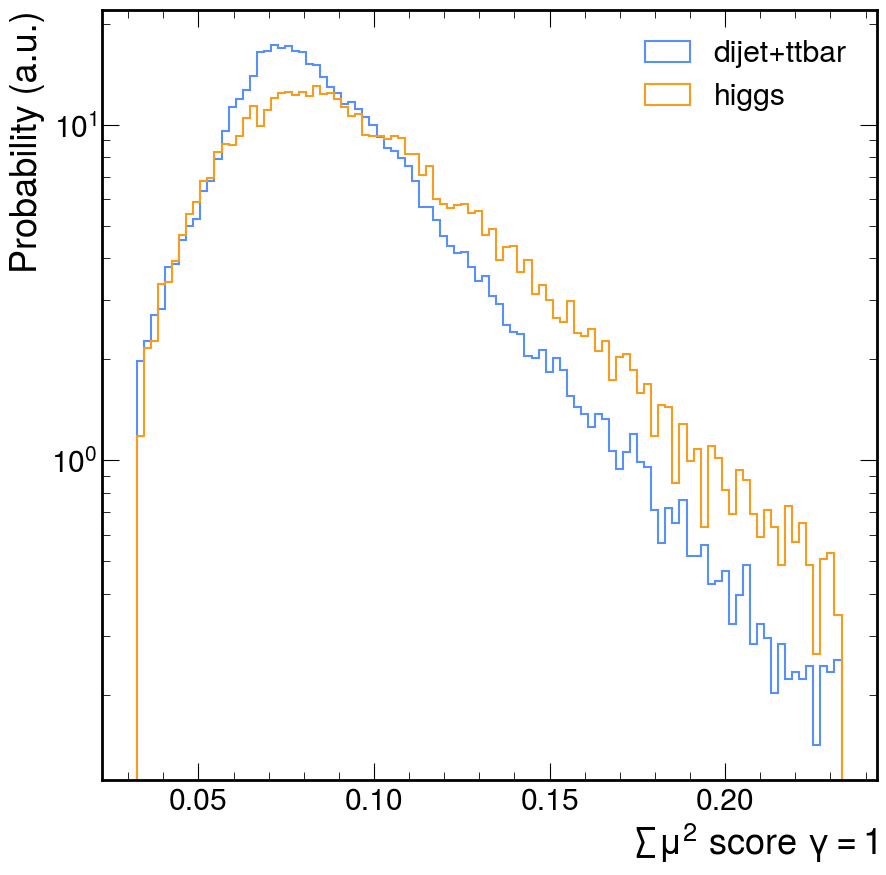

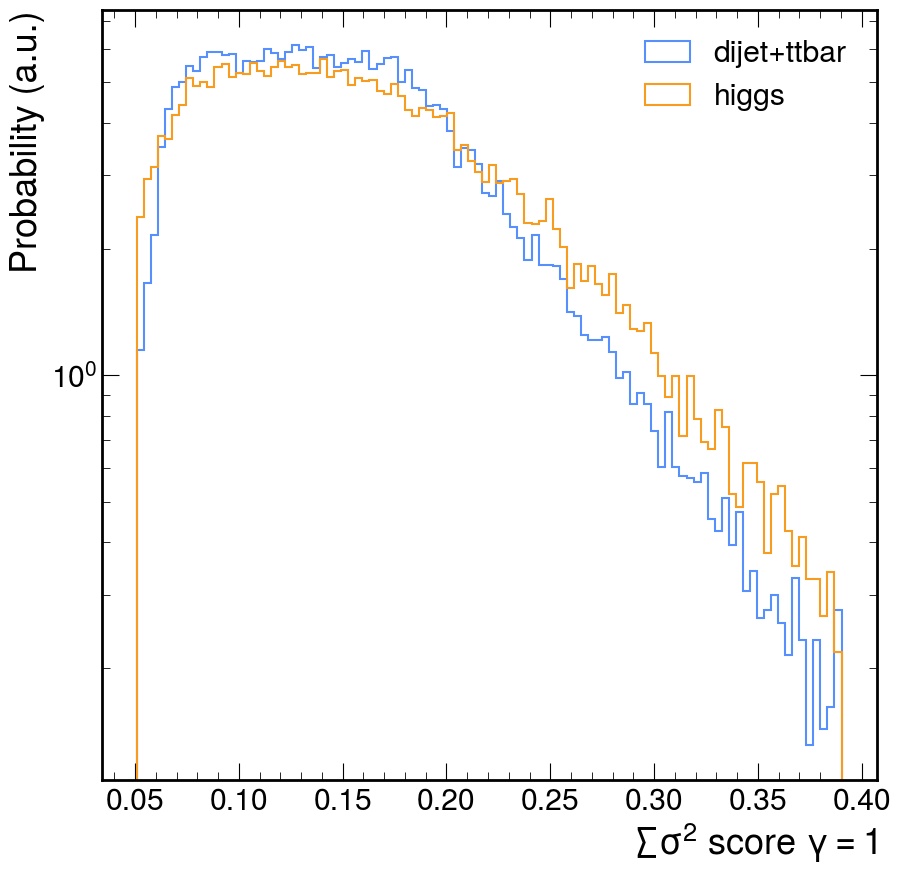

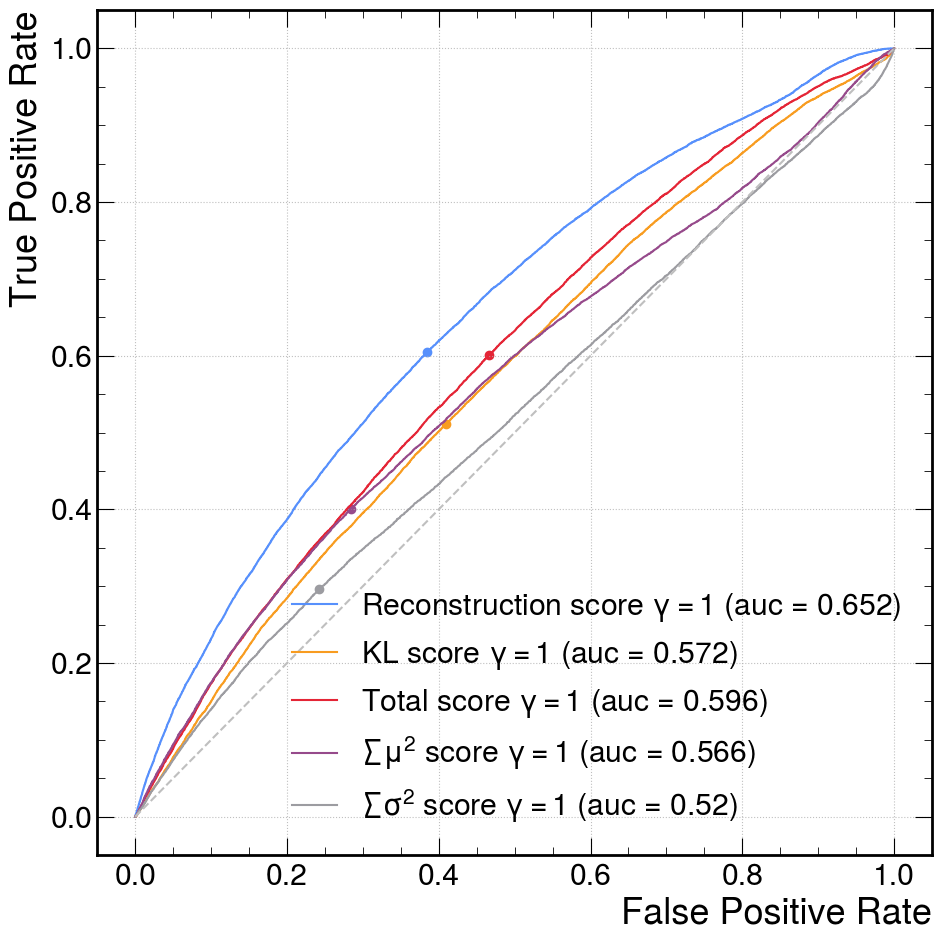

The distributions for dijet+ttbar recon cut are significantly different value=0.028.
No significant difference between the distributions for higgs recon cut with value=0.009.
The distributions for dijet+ttbar KL cut are significantly different value=0.015.
No significant difference between the distributions for higgs KL cut with value=0.01.
The distributions for dijet+ttbar total cut are significantly different value=0.014.
No significant difference between the distributions for higgs total cut with value=0.011.
The distributions for dijet+ttbar $\sum \mu^2$ score cut $\gamma=1$ are significantly different value=0.026.
No significant difference between the distributions for higgs $\sum \mu^2$ score cut $\gamma=1$ with value=0.016.
The distributions for dijet+ttbar $\sigma \mu^2$ score cut $\gamma=1$ are significantly different value=0.016.
No significant difference between the distributions for higgs $\sigma \mu^2$ score cut $\gamma=1$ with value=0.011.


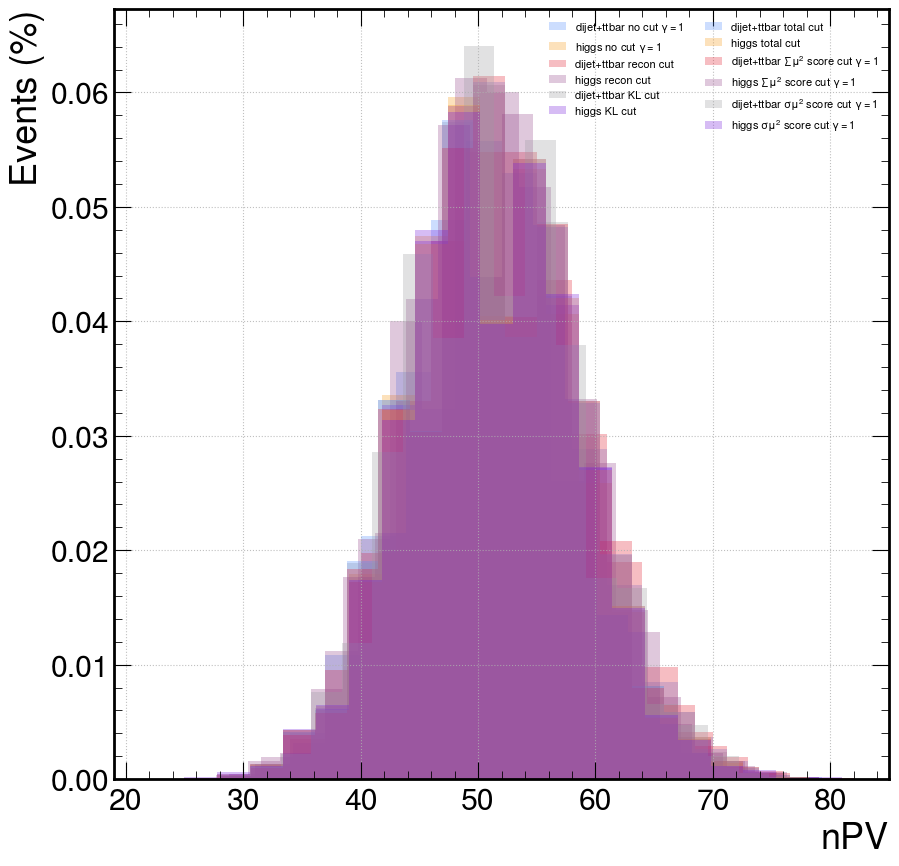

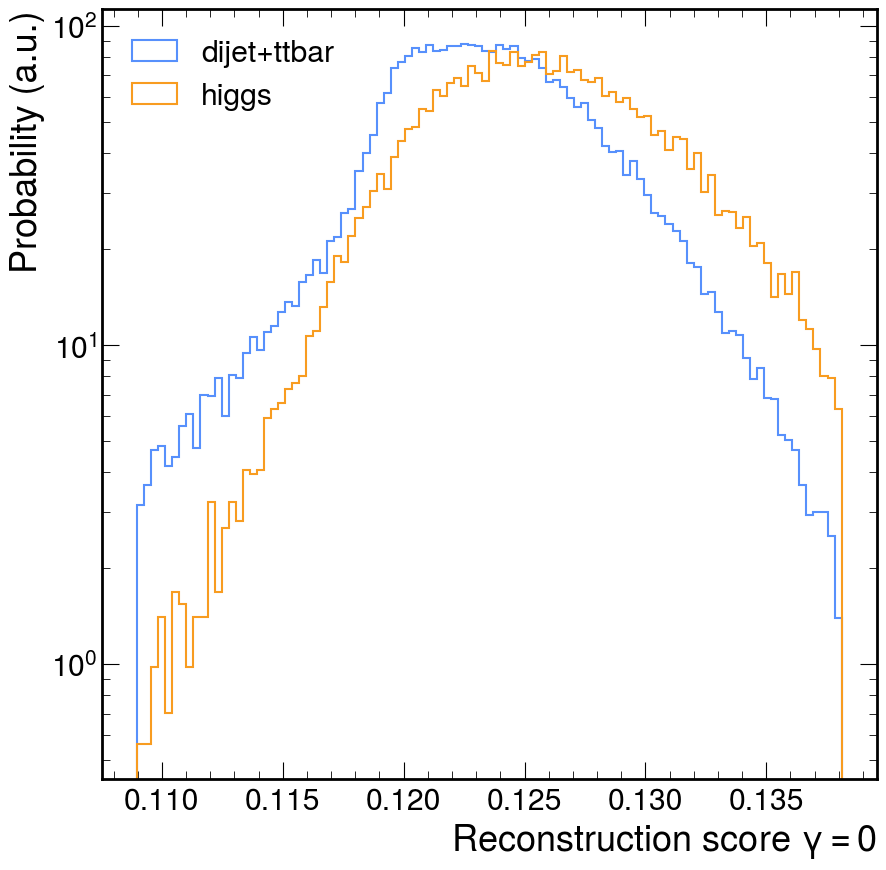

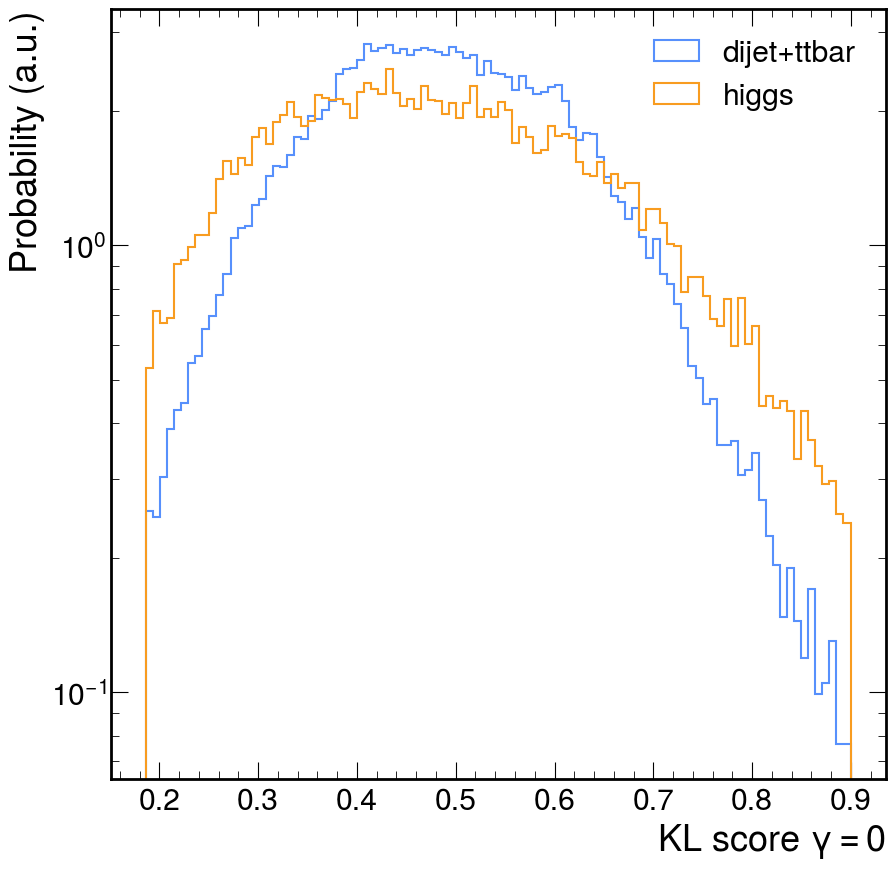

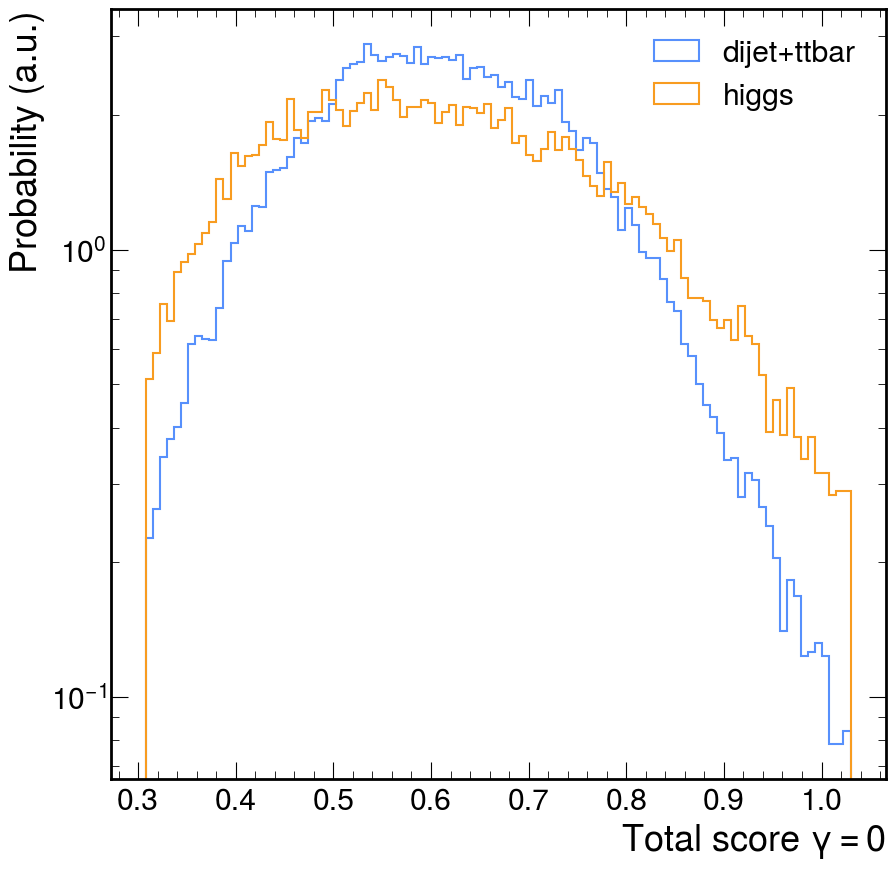

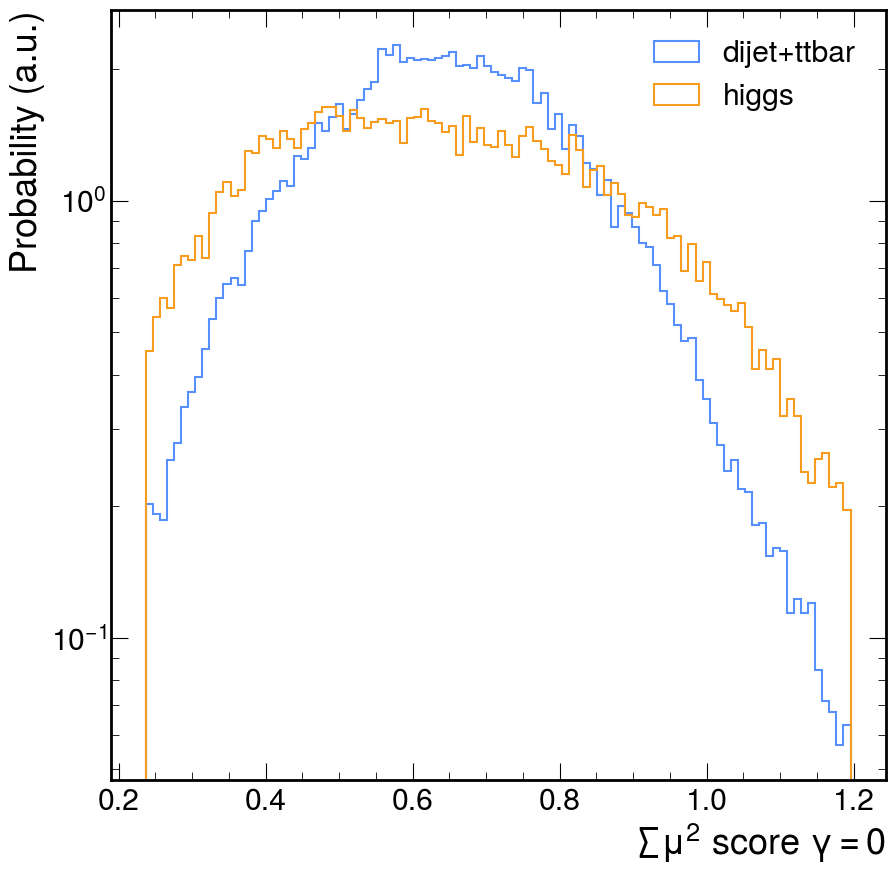

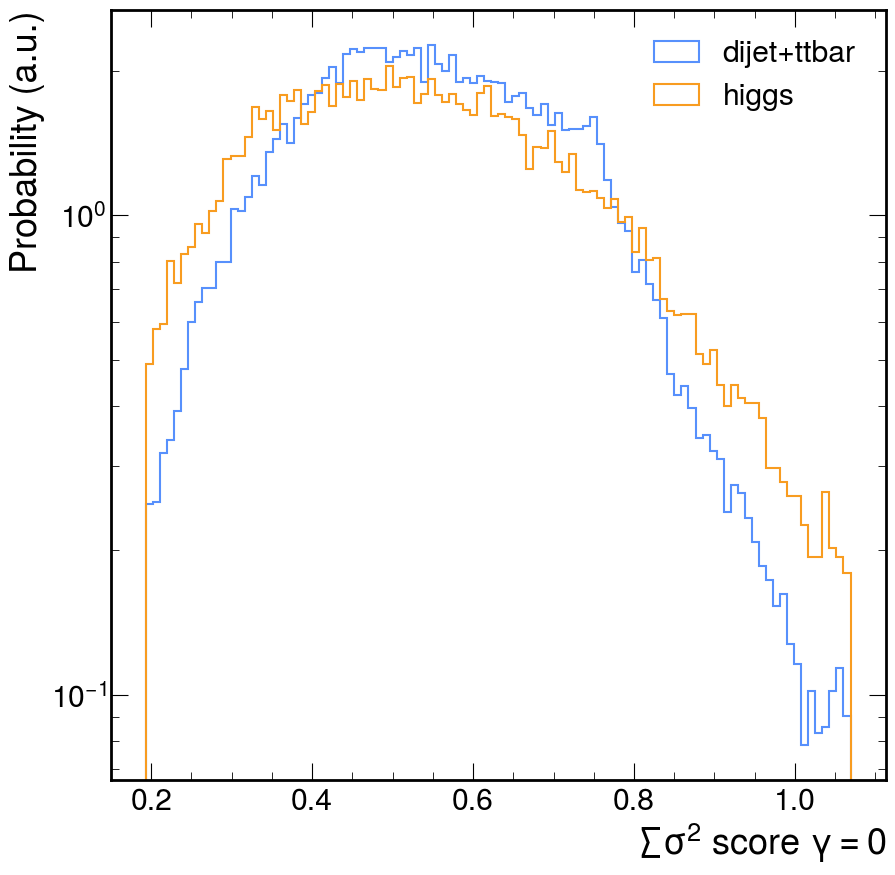

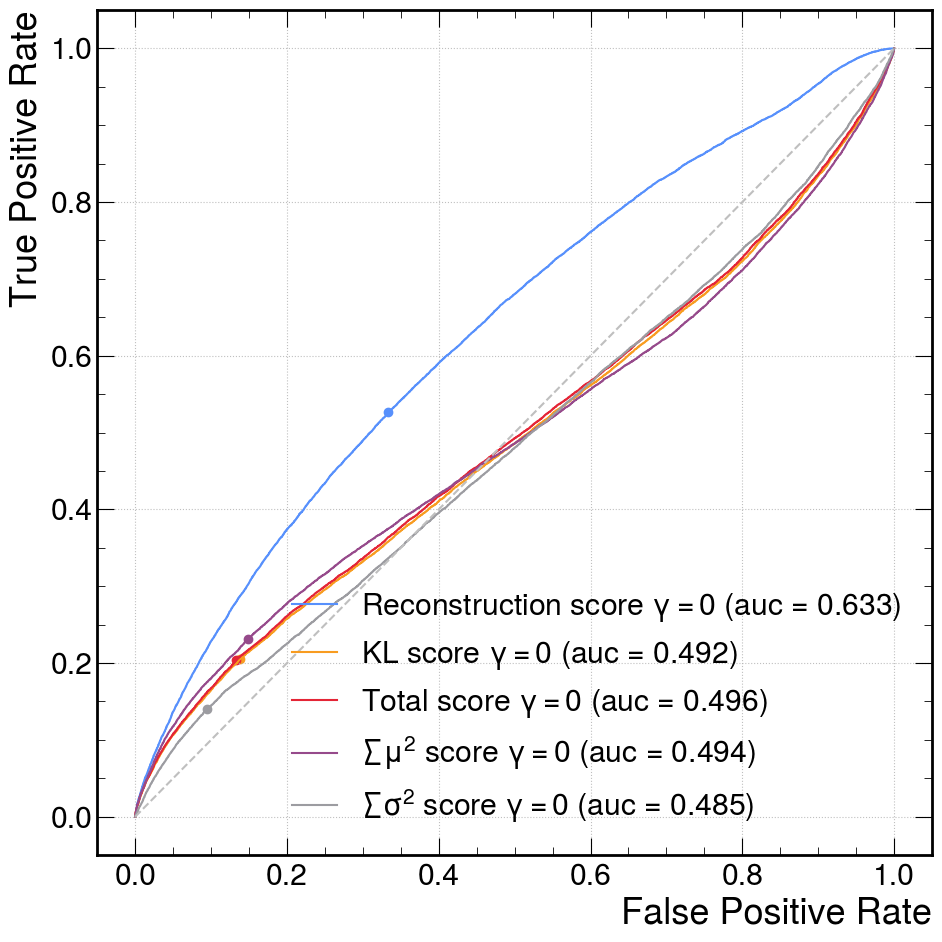

The distributions for dijet+ttbar recon cut are significantly different value=0.032.
No significant difference between the distributions for higgs recon cut with value=0.012.
The distributions for dijet+ttbar KL cut are significantly different value=0.027.
No significant difference between the distributions for higgs KL cut with value=0.012.
The distributions for dijet+ttbar total cut are significantly different value=0.029.
No significant difference between the distributions for higgs total cut with value=0.012.
The distributions for dijet+ttbar $\sum \mu^2$ score cut $\gamma=0$ are significantly different value=0.026.
No significant difference between the distributions for higgs $\sum \mu^2$ score cut $\gamma=0$ with value=0.016.
No significant difference between the distributions for dijet+ttbar $\sigma \mu^2$ score cut $\gamma=0$ with value=0.018.
No significant difference between the distributions for higgs $\sigma \mu^2$ score cut $\gamma=0$ with value=0.008.


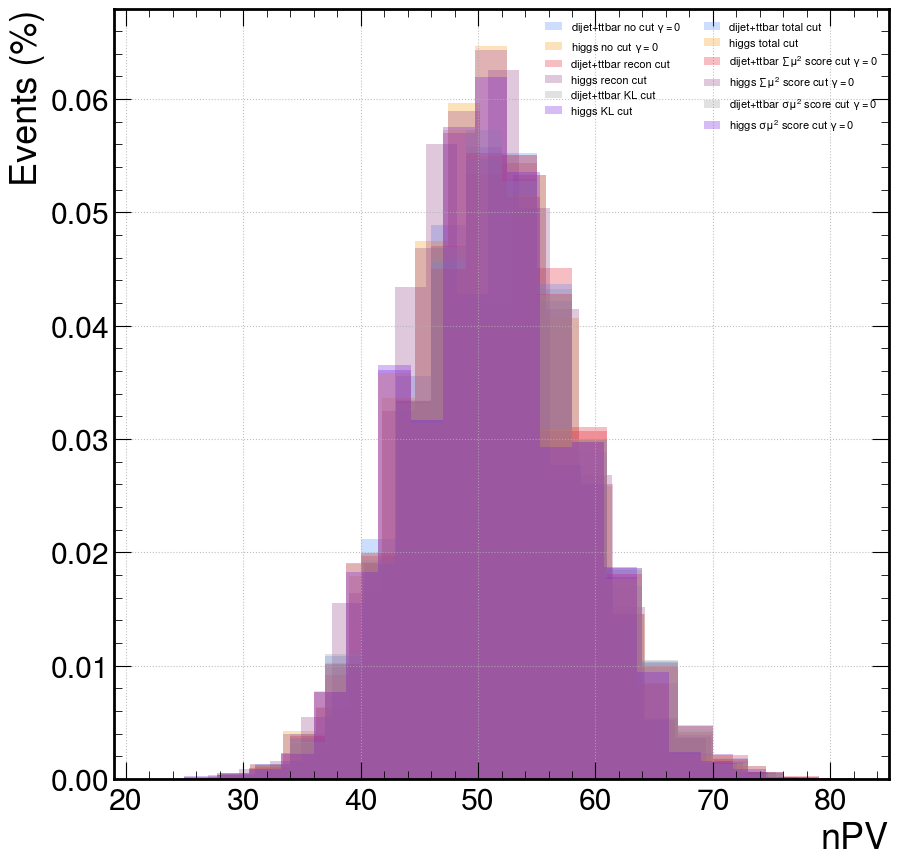

In [10]:
plot_history(history)
get_plots(MiVAE_model, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=1$")
get_plots(MiVAE_model_gamma_zero, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=0$")

### Analyse real data

In [13]:
# load model and scaling parameters
axol1tl_model = tf.keras.models.load_model('../data/encoder_trimmed.h5', custom_objects=co)

input_quantizer = quantized_bits(8,5,alpha=1)
scales = h5py.File('../data/scales.h5')
scale_data = scales['norm_scale'][:].flatten()
offset_data = scales['norm_bias'][:].flatten()

In [7]:
# prepare background data for inference
NEG=4
NMU=4
NJET=10

# read in normal data
X = readFromAnomalyBackgroundh5('../data/run370293.h5', object_ranges='default2')

X_flat = np.zeros((X[0]['nEvents'], 57), dtype='int')
X_flat[:,0] = ak.flatten(X[2].sums[:].pt)
X_flat[:,2] = ak.flatten(X[2].sums[:].phi)
X_flat[:,3:3+3*(NEG)] = awkward_to_numpy(X[2].egs, NEG)
X_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(X[2].muons, NMU)
X_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(X[2].jets, NJET)

# scale data and get pile-up
nPV = ak.to_numpy(X[1]['nPV'])
nPV_Good = ak.to_numpy(X[1]['nPV_Good'])
X_scaled = input_quantizer((X_flat.astype('float') - offset_data) / scale_data)
batch_size = len(X_scaled)

# read in abnormal data
cms_HHHTo6B = readFromAnomalySignalh5('../data/BSM_preprocessed.h5', 'HHHTo6B', object_ranges='default2')

cms_HHHTo6B_flat = np.zeros((cms_HHHTo6B[0]['nEvents'], 57), dtype='int')
cms_HHHTo6B_flat[:,0] = ak.flatten(cms_HHHTo6B[2].sums[:].pt)
cms_HHHTo6B_flat[:,2] = ak.flatten(cms_HHHTo6B[2].sums[:].phi)
cms_HHHTo6B_flat[:,3:3+3*(NEG)] = awkward_to_numpy(cms_HHHTo6B[2].egs, NEG)
cms_HHHTo6B_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(cms_HHHTo6B[2].muons, NMU)
cms_HHHTo6B_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(cms_HHHTo6B[2].jets, NJET)

# scale abnormal data
cms_HHHTo6B_scaled = input_quantizer((cms_HHHTo6B_flat.astype('float') - offset_data) / scale_data)

In [70]:
# split data for training / testing
partial_data = -1
X_train, X_test, nPV_train, nPV_test = train_test_split(X_scaled.numpy()[:partial_data], nPV_Good[:partial_data], random_state=42)

In [71]:
nPV_test

array([44, 36, 26, ..., 55, 27, 31], dtype=uint64)

In [73]:
# train the model
MiVAE_cms_model = MiVAE(
    verbose=2,
    activation="relu",
    batch_size=256,
    beta_param=1,
    drop_out=0.2,
    epoch=20,
    gamma=1,
    num_samples=10,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    quantize=True,
    run_eagerly=False
)
history = MiVAE_cms_model.fit(X_train, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 32)        │      1,856 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 32)        │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 16)        │        528 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 16)        │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │        136 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │        136 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_10         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_10[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,656 (10.38 KB)

 Trainable params: 2,656 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,569 (10.04 KB)

 Trainable params: 2,569 (10.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9224/9224 - 25s - 3ms/step - kl_loss: 4934721.0000 - loss: 4934722.5000 - mi_loss: 0.1031 - reconstruction_loss: 4.7694
Epoch 2/20
9224/9224 - 23s - 2ms/step - kl_loss: 213545.0000 - loss: 213549.5625 - mi_loss: 0.0785 - reconstruction_loss: 4.6721
Epoch 3/20
9224/9224 - 22s - 2ms/step - kl_loss: 54547.3945 - loss: 54552.4531 - mi_loss: 0.0693 - reconstruction_loss: 4.6653
Epoch 4/20
9224/9224 - 22s - 2ms/step - kl_loss: 25449.3105 - loss: 25454.2402 - mi_loss: 0.0636 - reconstruction_loss: 4.6634
Epoch 5/20
9224/9224 - 23s - 2ms/step - kl_loss: 12357.1641 - loss: 12361.8564 - mi_loss: 0.0600 - reconstruction_loss: 4.6626
Epoch 6/20
9224/9224 - 23s - 2ms/step - kl_loss: 7021.5879 - loss: 7026.3125 - mi_loss: 0.0570 - reconstruction_loss: 4.6622
Epoch 7/20
9224/9224 - 22s - 2ms/step - kl_loss: 4708.5713 - loss: 4713.2939 - mi_loss: 0.0552 - reconstruction_loss: 4.6619
Epoch 8/20
9224/9224 - 21s - 2ms/step - kl_loss: 3409.4583 - loss: 3414.1755 - mi_loss: 0.0530 - reconstructi

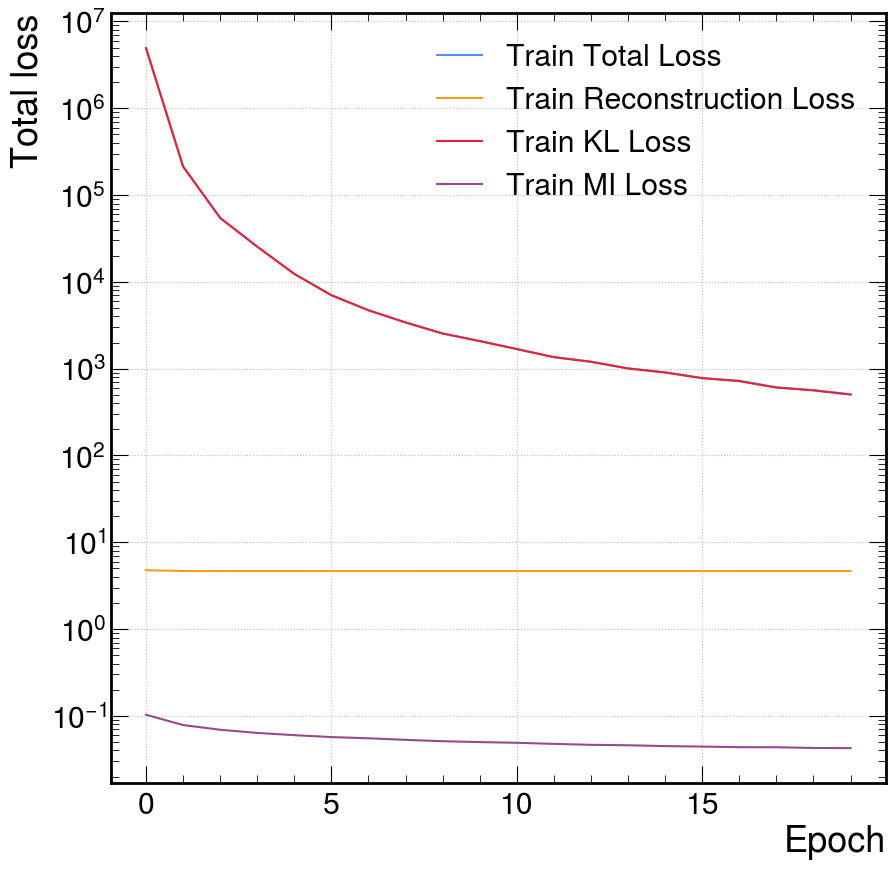

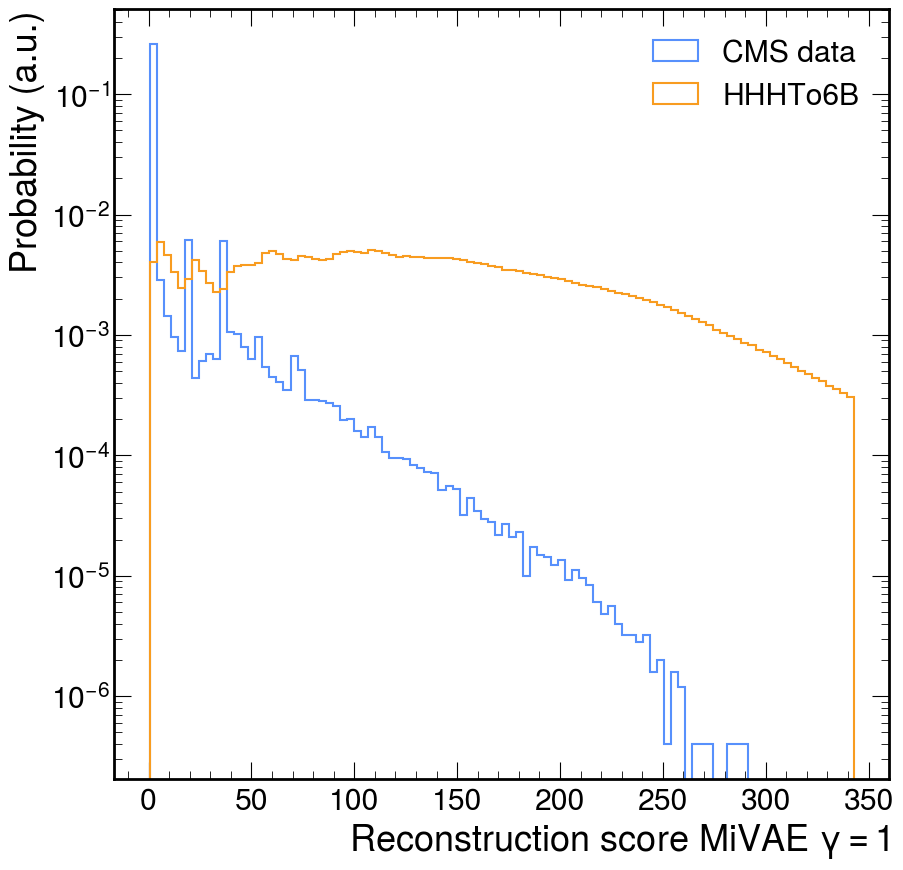

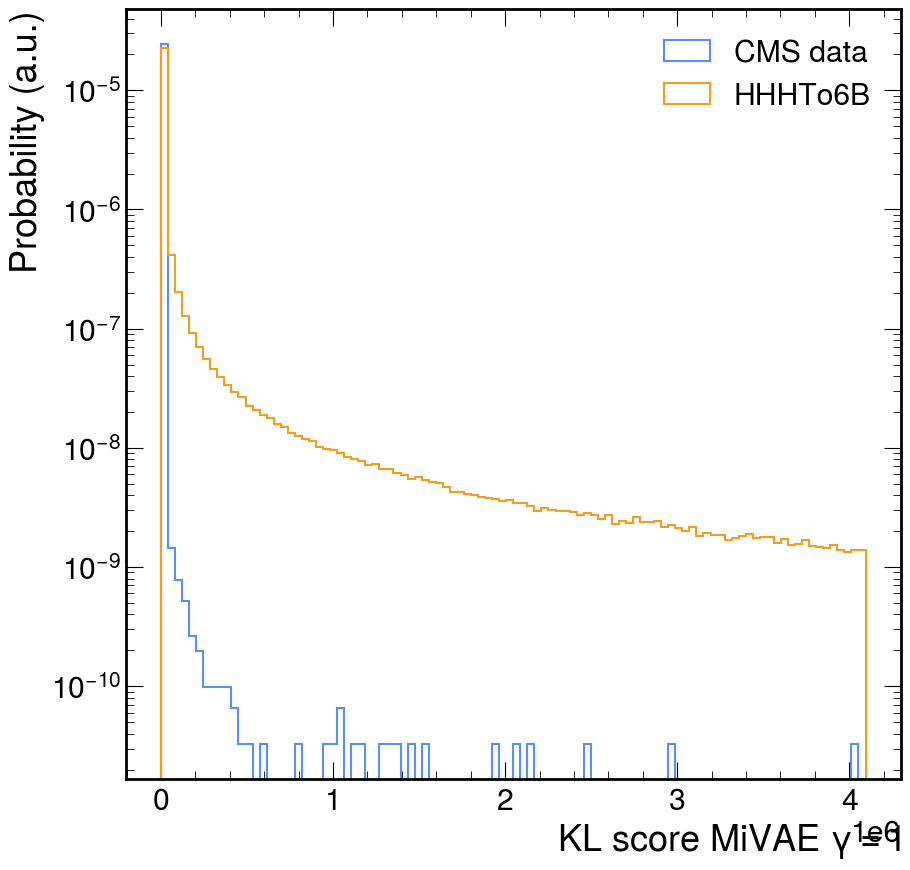

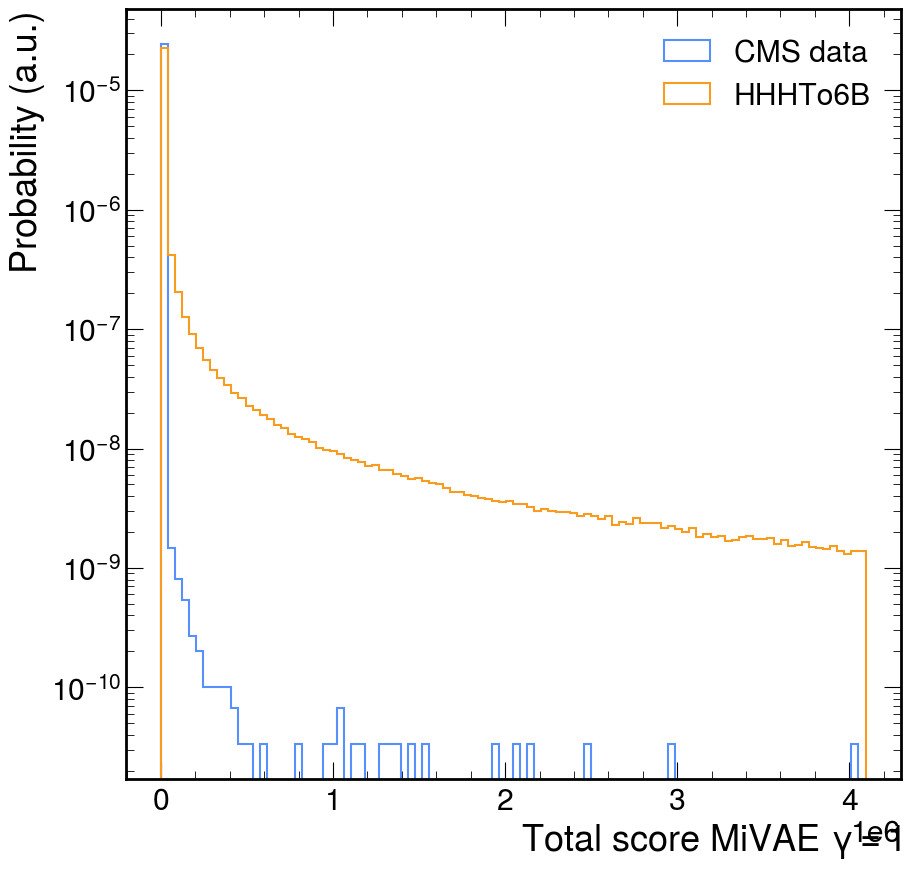

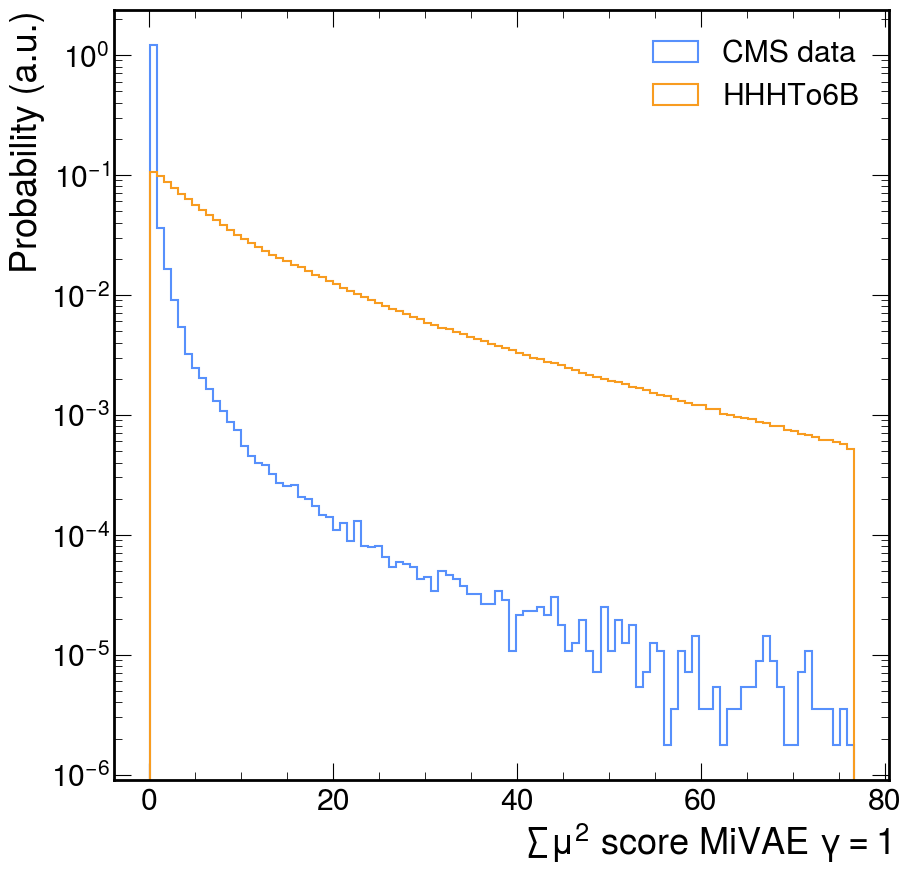

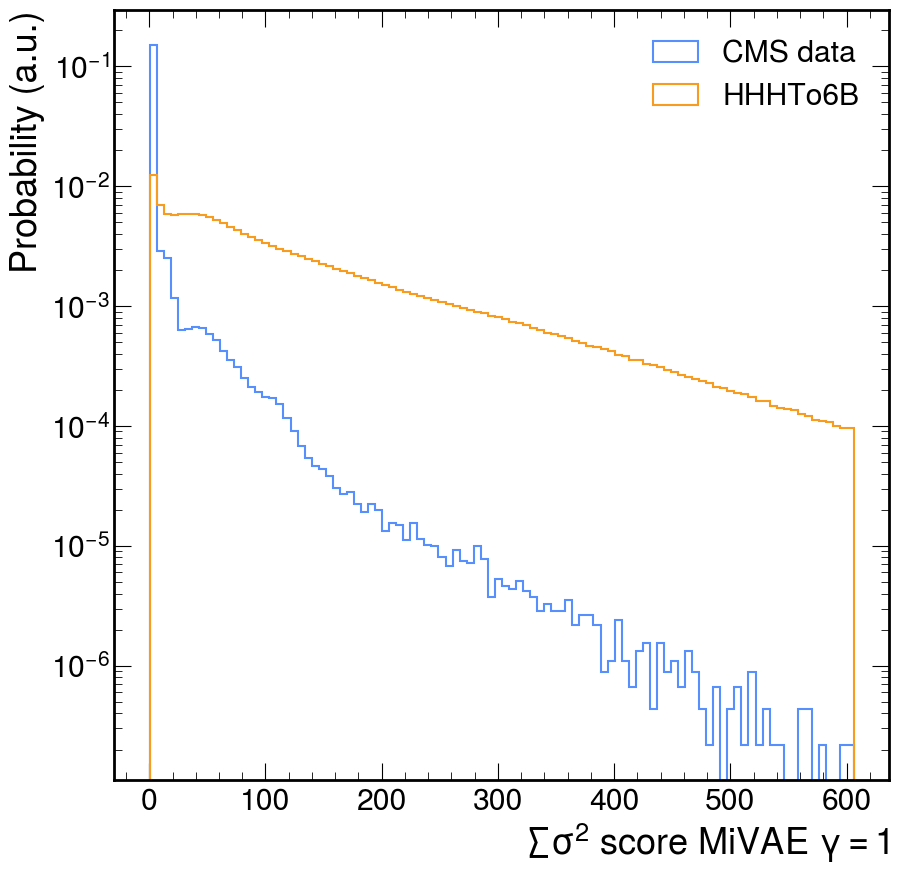

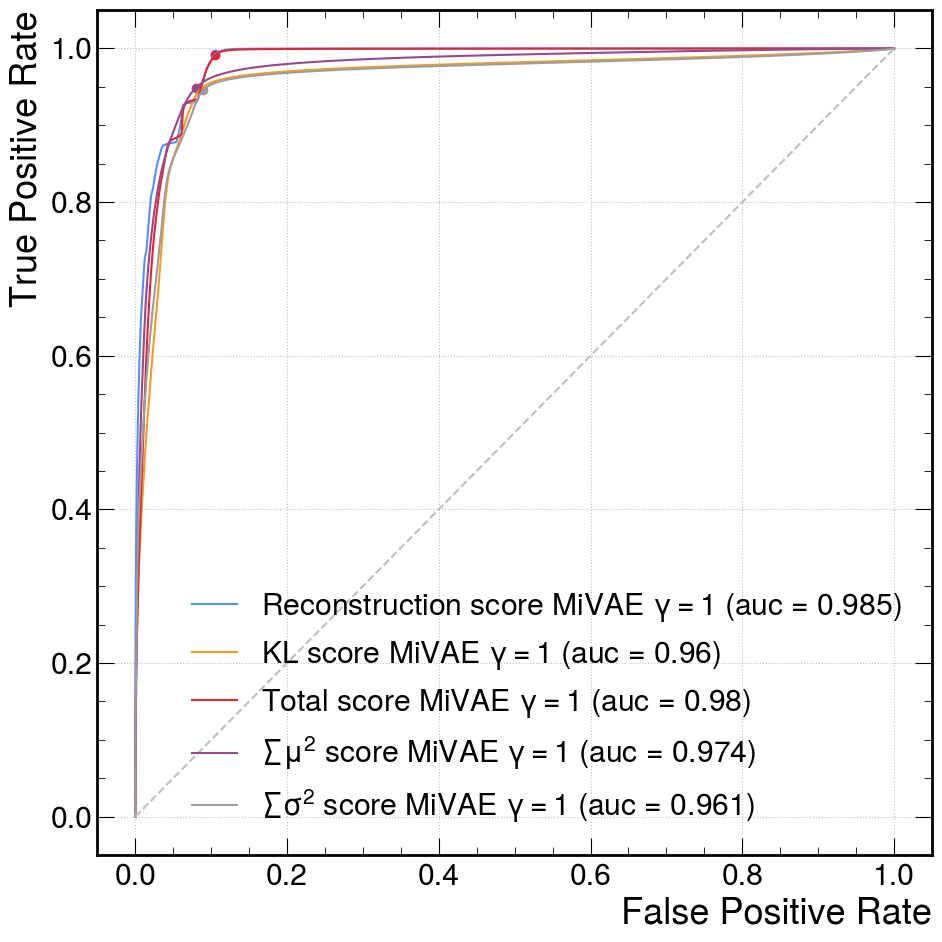

The distributions for CMS data recon cut are significantly different value=0.2.
The distributions for CMS data KL cut are significantly different value=0.191.
The distributions for CMS data total cut are significantly different value=0.199.
The distributions for CMS data $\sum \mu^2$ score cut MiVAE $\gamma=1$ are significantly different value=0.209.
The distributions for CMS data $\sigma \mu^2$ score cut MiVAE $\gamma=1$ are significantly different value=0.189.


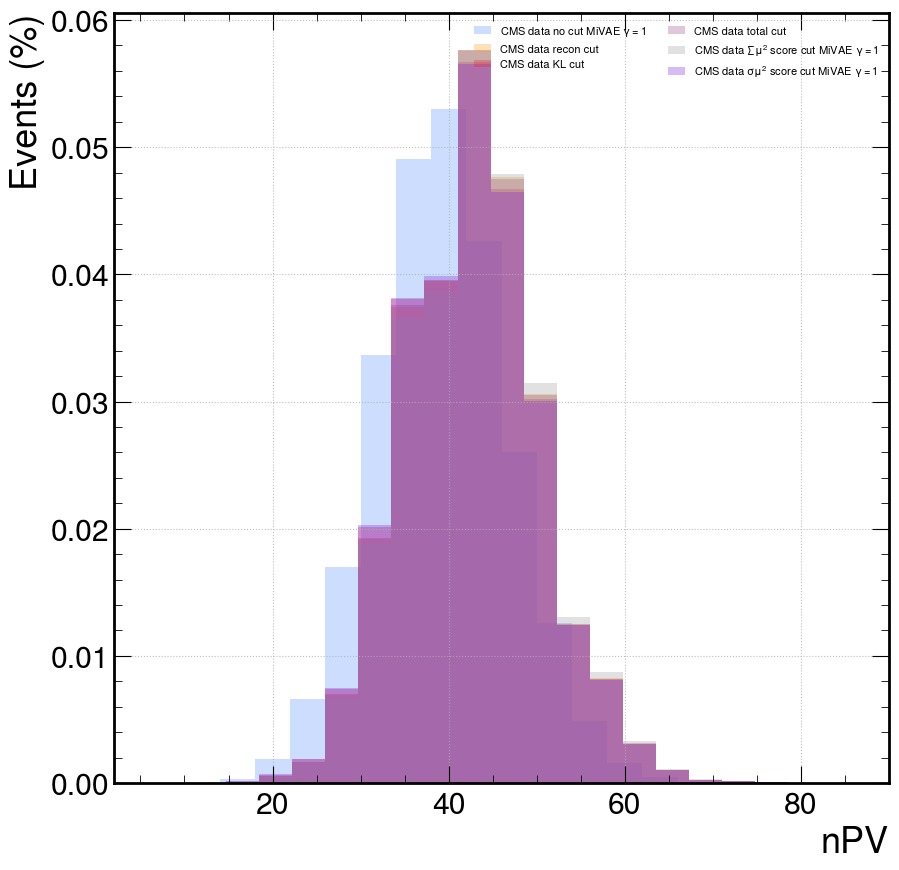

In [74]:
plot_history(history)
get_plots(MiVAE_cms_model, X_test, cms_HHHTo6B_scaled[:partial_data], nPV_test, None, name=r"MiVAE $\gamma=1$", label_normal="CMS data", label_abnormal="HHHTo6B")

24595/24595 ━━━━━━━━━━━━━━━━━━━━ 6s 246us/step
153160/153160 ━━━━━━━━━━━━━━━━━━━━ 37s 244us/step


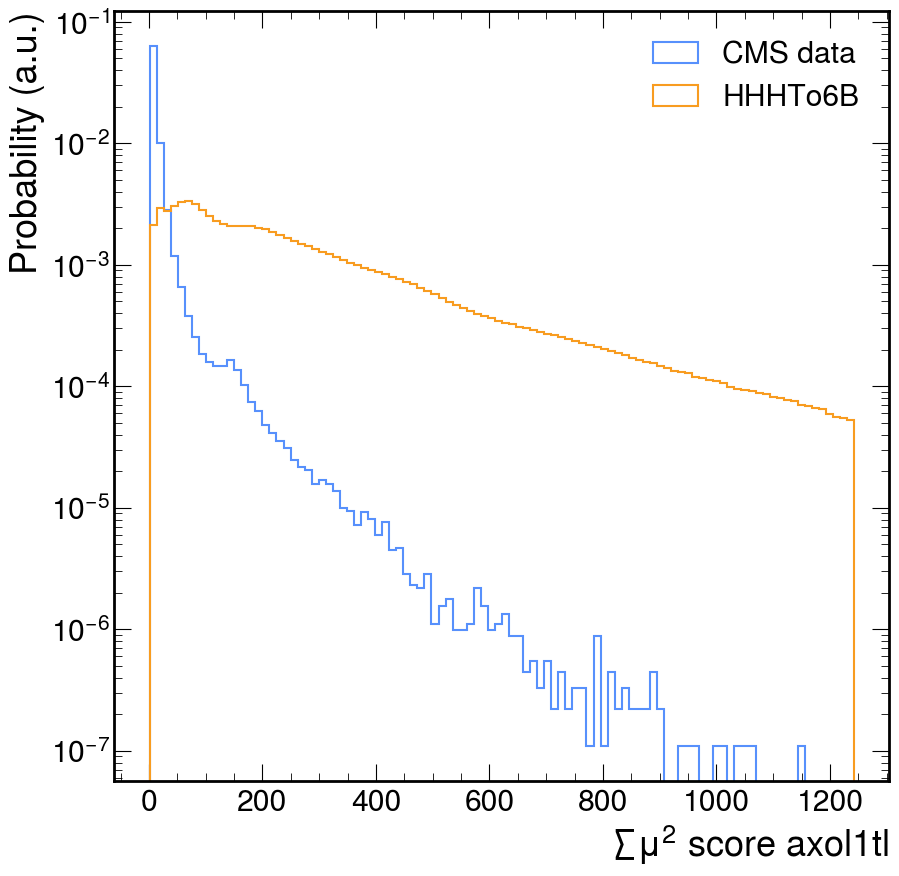

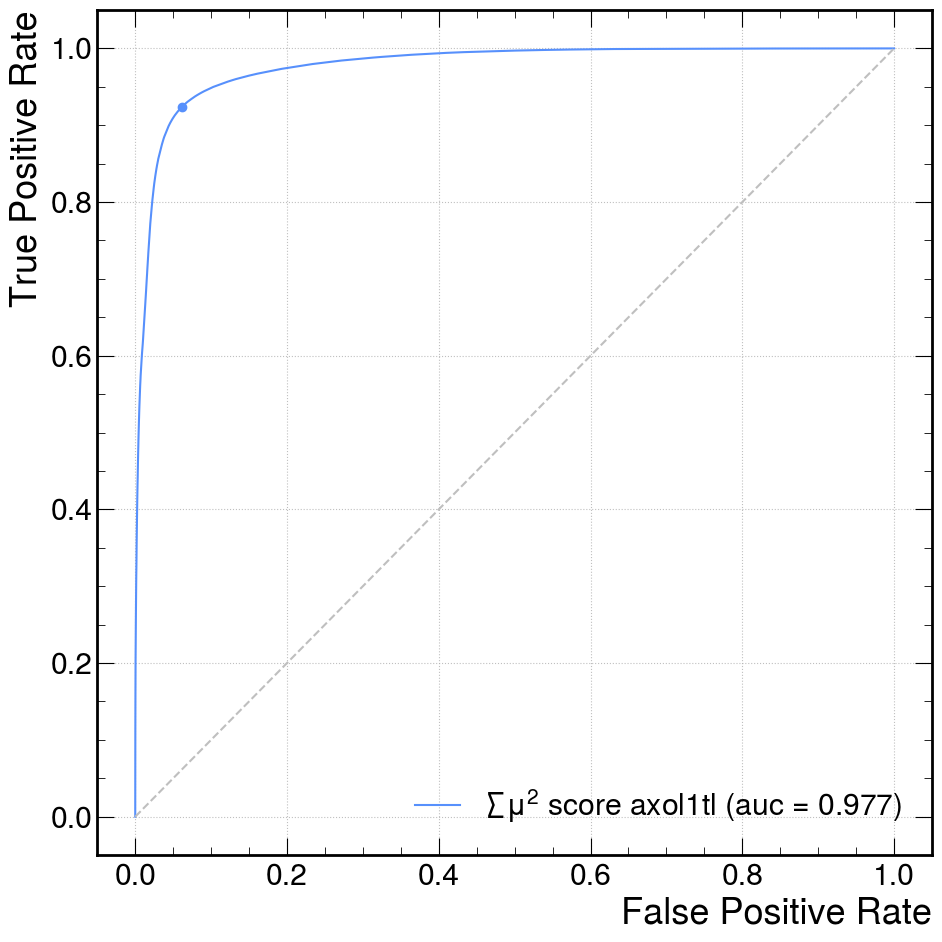

The distributions for CMS data $\sum \mu^2$ score are significantly different value=0.206.


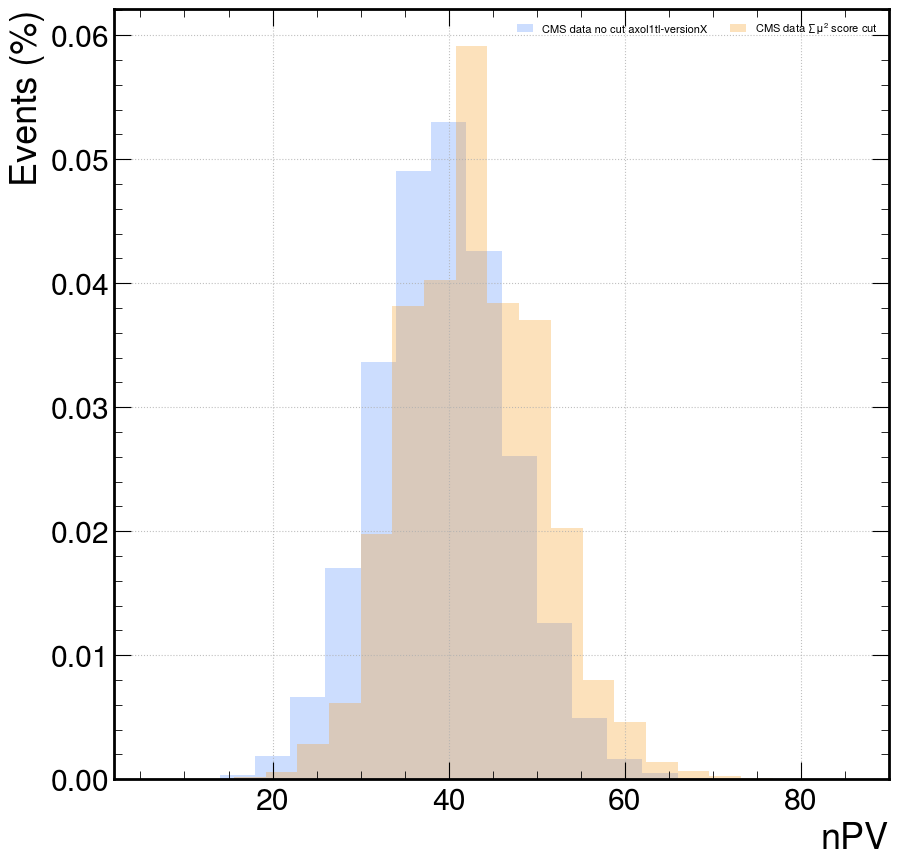

In [75]:
get_plots(axol1tl_model, X_test, cms_HHHTo6B_scaled[:partial_data], nPV_test, None, name="axol1tl-versionX", label_normal="CMS data", label_abnormal="HHHTo6B", use_axio=True)

In [35]:
axol1tl_model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_3 (InputLayer)            │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ q_dense (QDense)                │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ q_dense_1 (QDense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mu (QDense)                     │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,520 (9.84 KB)

 Trainable params: 2,520 (9.84 KB)

 Non-trainable params: 0 (0.00 B)